In [1]:
from misc import HP
import argparse
import random
import time
import pickle
import copy
import SYCLOP_env as syc
from misc import *
import sys
import os
import cv2
import argparse
import tensorflow.keras as keras

from keras_networks import rnn_model_102, rnn_model_multicore_201, rnn_model_multicore_202
from curriculum_utils import create_mnist_dataset, bad_res102

In [2]:

def generate_trajectory(n_steps,max_q,acceleration_mode):
    starting_point = np.array([max_q[0] // 2, max_q[1] // 2])
    steps = []
    qdot=0
    for j in range(n_steps):
        steps.append(starting_point * 1)
        if acceleration_mode:
            qdot += np.random.randint(-1, 2, 2)
            starting_point += qdot
        else:
            starting_point += np.random.randint(-5, 6, 2)
    return np.array(steps)

In [11]:
def split_dataset_xy(dataset):
    dataset_x1 = [uu[0] for uu in dataset]
    dataset_x2 = [uu[1] for uu in dataset]
    dataset_y = [uu[-1] for uu in dataset]
    return (np.array(dataset_x1)[...,np.newaxis],np.array(dataset_x2)[:,:n_timesteps,:]),np.array(dataset_y)

#parse hyperparameters

lsbjob = os.getenv('LSB_JOBID')
lsbjob = '' if lsbjob is None else lsbjob

hp = HP()
hp.save_path = 'saved_runs'
hp.description=''
parser = argparse.ArgumentParser()
parser.add_argument('--tau_int', default=4., type=float, help='Integration timescale for adaaptation')
parser.add_argument('--resize', default=1.0, type=float, help='resize of images')
parser.add_argument('--run_name_suffix', default='', type=str, help='suffix for runname')
parser.add_argument('--eval_dir', default=None, type=str, help='eval dir')

parser.add_argument('--dqn_initial_network', default=None, type=str, help='dqn_initial_network')
parser.add_argument('--decoder_initial_network', default=None, type=str, help='decoder_initial_network')
parser.add_argument('--decoder_arch', default='default', type=str, help='decoder_network architecture: default / multicore_201')
parser.add_argument('--decoder_n_cores',  default=1, type=int, help='decoder number of cores')

parser.add_argument('--decoder_learning_rate',  default=1e-3, type=float, help='decoder learning rate')
parser.add_argument('--decoder_dropout',  default=0.0, type=float, help='decoder dropout')
parser.add_argument('--decoder_rnn_type',  default='gru', type=str, help='gru or rnn')
parser.add_argument('--decoder_rnn_units',  default=100, type=int, help='decoder rnn units')
parser.add_argument('--decoder_rnn_layers',  default=1, type=int, help='decoder rnn units')


parser.add_argument('--decoder_ignore_position', dest='decoder_ignore_position', action='store_true')
parser.add_argument('--no-decoder_ignore_position', dest='decoder_ignore_position', action='store_false')

parser.add_argument('--syclop_learning_rate',  default=2.5e-3, type=float, help='syclop (RL) learning rate')

parser.add_argument('--color', default='grayscale', type=str, help='grayscale/rgb')
parser.add_argument('--speed_reward',  default=0.0, type=float, help='speed reward, typically negative')
parser.add_argument('--intensity_reward',  default=0.0, type=float, help='speed penalty reward')
parser.add_argument('--loss_reward',  default=-1.0, type=float, help='reward for loss, typically negative')
parser.add_argument('--resolution',  default=28, type=int, help='resolution')
parser.add_argument('--max_eval_episodes',  default=10000, type=int, help='episodes for evaluation mode')
parser.add_argument('--steps_per_episode',  default=5, type=int, help='time steps in each episode in ')
parser.add_argument('--fit_verbose',  default=1, type=int, help='verbose level for model.fit                        ')
parser.add_argument('--steps_between_learnings',  default=100, type=int, help='steps_between_learnings')
parser.add_argument('--num_epochs',  default=100, type=int, help='steps_between_learnings')

parser.add_argument('--alpha_increment',  default=0.01, type=float, help='reward for loss, typically negative')


parser.add_argument('--beta_t1',  default=400000, type=int, help='time rising bete')
parser.add_argument('--beta_t2',  default=700000, type=int, help='end rising beta')
parser.add_argument('--beta_b1',  default=0.1, type=float, help='beta initial value')
parser.add_argument('--beta_b2',  default=1.0, type=float, help='beta final value')

parser.add_argument('--curriculum_enable', dest='curriculum_enable', action='store_true')
parser.add_argument('--no-curriculum_enable', dest='curriculum_enable', action='store_false')

parser.add_argument('--conv_fe', dest='conv_fe', action='store_true')
parser.add_argument('--no-conv_fe', dest='conv_fe', action='store_false')

parser.add_argument('--acceleration_mode', dest='acceleration_mode', action='store_true')
parser.add_argument('--no-acceleration_mode', dest='acceleration_mode', action='store_false')


parser.set_defaults(eval_mode=False, decode_from_dvs=False,test_mode=False,rising_beta_schedule=True,decoder_ignore_position=False, curriculum_enable=True, conv_fe=False,
                    acceleration_mode=True)
config = parser.parse_args('')

# config = parser.parse_args()
config = vars(config)
hp.upadte_from_dict(config)
hp.this_run_name = sys.argv[0] + '_noname_' + hp.run_name_suffix + '_' + lsbjob + '_' + str(int(time.time()))

#define model
n_timesteps = hp.steps_per_episode

##
# deploy_logs()
##
# if hp.decoder_arch == 'multicore_201':
#     decoder = rnn_model_multicore_201(n_cores=hp.decoder_n_cores,lr=hp.decoder_learning_rate,ignore_input_B=hp.decoder_ignore_position,dropout=hp.decoder_dropout,rnn_type=hp.decoder_rnn_type,
#                                 input_size=(hp.resolution,hp.resolution, 1),rnn_layers=hp.decoder_rnn_layers,conv_fe=hp.conv_fe, rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
# if hp.decoder_arch == 'multicore_202':
#     decoder = rnn_model_multicore_202(n_cores=hp.decoder_n_cores, lr=hp.decoder_learning_rate,
#                                       ignore_input_B=hp.decoder_ignore_position, dropout=hp.decoder_dropout,
#                                       rnn_type=hp.decoder_rnn_type,
#                                       input_size=(hp.resolution, hp.resolution, 1),
#                                       rnn_layers=hp.decoder_rnn_layers, conv_fe=hp.conv_fe,
#                                       rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
# elif hp.decoder_arch == 'default':
#     decoder = rnn_model_102(lr=hp.decoder_learning_rate,ignore_input_B=hp.decoder_ignore_position,dropout=hp.decoder_dropout,rnn_type=hp.decoder_rnn_type,
#                                 input_size=(hp.resolution,hp.resolution, 1),rnn_layers=hp.decoder_rnn_layers,conv_fe=hp.conv_fe,rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
decoder_initial_network = 'saved_runs/trajectory_curriculum101.py_noname__613128_1624010531_1//final_decoder.nwk'
decoder = keras.models.load_model(decoder_initial_network)
    #define dataset
(images, labels), (images_test, labels_test) = keras.datasets.mnist.load_data(path="mnist.npz")


#fit one epoch in a  time
# scheduler = Scheduler(hp.lambda_schedule)
# for epoch in range(hp.num_epochs):
#     lambda_epoch = scheduler.step(epoch)

In [12]:
hp.acceleration_mode

True

In [13]:
alpha=0
hp.num_trials = 30
trajectories = []
train_pred_pred = []
val_pred_pred = []
for trial in range(hp.num_trials):
    this_trajectory=generate_trajectory(hp.steps_per_episode,[72,72],hp.acceleration_mode)
#     this_trajectory=trajectories[trial]
    train_dataset, test_dataset = create_mnist_dataset(images, labels, 6, sample=hp.steps_per_episode, bad_res_func=bad_res102,
                                                           return_datasets=True, q_0=this_trajectory, alpha=0.0,
                                                           random_trajectories=True,acceleration_mode=hp.acceleration_mode)
    train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset)
    test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset)
    q_prime = train_dataset_x[1][0]
#     print('epoch', epoch, '  CONTROL!!!',' first q --', q_prime.reshape([-1]))

    print("evaluating trajectory  ", trial)
    train_preds = decoder.predict(
        train_dataset_x,
        batch_size=64,
        verbose=hp.fit_verbose,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        )
    val_preds = decoder.predict(
        test_dataset_x,
        batch_size=64,
        verbose=hp.fit_verbose,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        )
    accuracy =  np.mean(np.argmax(val_preds, axis=1)==test_dataset_y)
    print('accuracy:', accuracy)
    trajectories.append(this_trajectory+0.)
    train_pred_pred.append(train_preds+0.0)
    val_pred_pred.append(val_preds+0.0)

Are we random? 5
evaluating trajectory   0
5000/5000 [==============================] - 1s 245us/sample
accuracy: 0.8166
Are we random? 4
evaluating trajectory   1
5000/5000 [==============================] - 1s 255us/sample
accuracy: 0.8478
Are we random? 17
evaluating trajectory   2
5000/5000 [==============================] - 1s 254us/sample
accuracy: 0.8238
Are we random? 2
evaluating trajectory   3
5000/5000 [==============================] - 1s 250us/sample
accuracy: 0.8318
Are we random? 15
evaluating trajectory   4
5000/5000 [==============================] - 1s 248us/sample
accuracy: 0.8292
Are we random? 12
evaluating trajectory   5
5000/5000 [==============================] - 1s 257us/sample
accuracy: 0.8412
Are we random? 1
evaluating trajectory   6
5000/5000 [==============================] - 1s 255us/sample
accuracy: 0.7984
Are we random? 18
evaluating trajectory   7
5000/5000 [==============================] - 1s 259us/sample
accuracy: 0.8478
Are we random? 2
evaluating 

In [9]:
accuracy =  np.mean(np.argmax(val_preds, axis=1)==test_dataset_y)

In [10]:
accuracy

0.8426

In [15]:
ent = np.zeros([np.shape(test_dataset_y)[0],hp.num_trials])
lablab = np.zeros([np.shape(test_dataset_y)[0],hp.num_trials])
for jj,preds in enumerate(val_pred_pred):
    ent[:,jj]=np.sum(-preds*np.log(preds),axis=1)
    lablab[:,jj]=np.argmax(preds, axis=1)

In [16]:
ii=np.argmin(ent,axis=1)

In [17]:
best_lbl=[]
for jj,uu in enumerate(ii):
    best_lbl.append(lablab[jj,uu])


In [18]:
np.mean(best_lbl==test_dataset_y)

0.9012

In [19]:
#random syclop, 
np.mean(lablab==test_dataset_y.reshape([-1,1]))

0.8134666666666667

In [20]:
accuracies=np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0)

In [21]:
best_ii=np.argmax(np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0))

In [22]:
np.mean(ii==best_ii)

0.1246

In [23]:
np.mean(np.any(lablab==test_dataset_y.reshape([-1,1]),axis=1))

0.9928

In [24]:
best_ent=np.min(ent,axis=1)

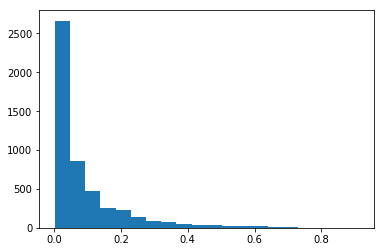

In [25]:
_=plt.hist(best_ent,bins=20)

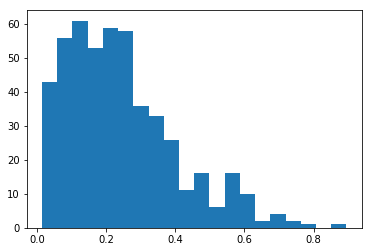

In [26]:
_=plt.hist(best_ent[best_lbl!=test_dataset_y],bins=20)

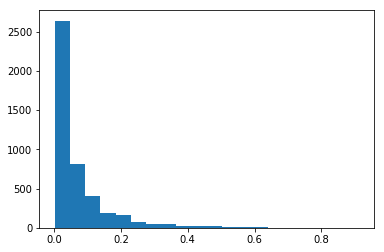

In [27]:
_=plt.hist(best_ent[best_lbl==test_dataset_y],bins=20)

In [29]:
super_pred=np.sum(val_pred_pred,axis=0)

In [30]:
super_label=np.argmax(super_pred,axis=1)

In [31]:
np.mean(super_label==test_dataset_y)

0.932

In [32]:
super_label.shape

(5000,)

In [33]:
with open('committee103s5_traj_30.pkl','wb') as f:
    pickle.dump(trajectories,f)

In [34]:
def super_pred_fun(pred,T=1):
    logits = np.log(pred)
    pred_T = np.exp(1./T*logits)
    pred_T = pred_T/np.sum(pred_T,axis=-1)[...,np.newaxis]
    super_pred=np.sum(pred_T,axis=0)
    return super_pred

In [35]:
super_pred = super_pred_fun(train_pred_pred)

In [36]:
super_pred = super_pred_fun(val_pred_pred,T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.936


In [37]:
np.linspace(0.1,5.0,100)

array([0.1       , 0.14949495, 0.1989899 , 0.24848485, 0.2979798 ,
       0.34747475, 0.3969697 , 0.44646465, 0.4959596 , 0.54545455,
       0.59494949, 0.64444444, 0.69393939, 0.74343434, 0.79292929,
       0.84242424, 0.89191919, 0.94141414, 0.99090909, 1.04040404,
       1.08989899, 1.13939394, 1.18888889, 1.23838384, 1.28787879,
       1.33737374, 1.38686869, 1.43636364, 1.48585859, 1.53535354,
       1.58484848, 1.63434343, 1.68383838, 1.73333333, 1.78282828,
       1.83232323, 1.88181818, 1.93131313, 1.98080808, 2.03030303,
       2.07979798, 2.12929293, 2.17878788, 2.22828283, 2.27777778,
       2.32727273, 2.37676768, 2.42626263, 2.47575758, 2.52525253,
       2.57474747, 2.62424242, 2.67373737, 2.72323232, 2.77272727,
       2.82222222, 2.87171717, 2.92121212, 2.97070707, 3.02020202,
       3.06969697, 3.11919192, 3.16868687, 3.21818182, 3.26767677,
       3.31717172, 3.36666667, 3.41616162, 3.46565657, 3.51515152,
       3.56464646, 3.61414141, 3.66363636, 3.71313131, 3.76262

In [38]:
super_pred = super_pred_fun(val_pred_pred[:15],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9356


In [39]:
super_pred = super_pred_fun(val_pred_pred[:5],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9194


In [40]:
super_pred = super_pred_fun(val_pred_pred[:2],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.8702


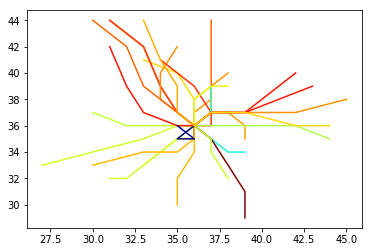

In [41]:
# x = np.linspace(0, 2*np.pi, 64)
# y = np.cos(x) 

# pl.figure()
# pl.plot(x,y)

n = hp.num_trials
# colors = plt.cm.jet(accuracies)
colors = plt.cm.jet((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))
# 
for trial in range(hp.num_trials):
    plt.plot(trajectories[trial][:,0],trajectories[trial][:,1],  color=colors[trial])
# plt.colorbar()

In [42]:
colors = plt.cm.jet((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))

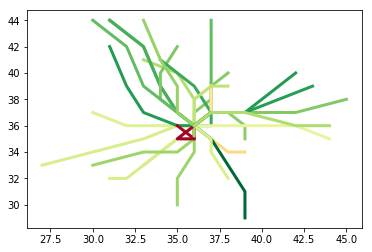

In [43]:
n = hp.num_trials
# colors = plt.cm.jet(accuracies)
colors = plt.cm.RdYlGn((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))
# 
for trial in range(hp.num_trials):
    plt.plot(trajectories[trial][:,0],trajectories[trial][:,1],  color=colors[trial],linewidth=3)

In [128]:
plt.cm.jet(1.0)

(0.5, 0.0, 0.0, 1.0)

In [ ]:
n_lines = hp.num_trials
x = np.arange(100)

yint = np.arange(0, n_lines*10, 10)
ys = np.array([x + b for b in yint])
xs = np.array([x for i in range(n_lines)]) # could also use np.tile

colors = np.arange(n_lines)

fig, ax = plt.subplots()
lc = multiline(xs, ys, yint, cmap='bwr', lw=2)

axcb = fig.colorbar(lc)
axcb.set_label('Y-intercept')
ax.set_title('Line Collection with mapped colors')

In [45]:
# Set the input shape
input_shape = (300,)
# print(f'Feature shape: {input_shape}')

# Create the model
model = keras.Sequential()
model.add(keras.layers.Dense(300, input_shape=input_shape, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(100,  activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

# Configure the model and start training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.transpose(train_pred_pred,[1,2,0]).reshape([-1,300]), train_dataset_y.astype(int), epochs=100, batch_size=250, verbose=1, validation_split=0.2)


Train on 44000 samples, validate on 11000 samples
Epoch 1/100
44000/44000 [==============================] - 3s 70us/sample - loss: 0.4232 - acc: 0.8942 - val_loss: 0.1964 - val_acc: 0.9452
Epoch 2/100
44000/44000 [==============================] - 2s 35us/sample - loss: 0.2114 - acc: 0.9469 - val_loss: 0.1776 - val_acc: 0.9505
Epoch 3/100
44000/44000 [==============================] - 2s 36us/sample - loss: 0.1877 - acc: 0.9527 - val_loss: 0.1606 - val_acc: 0.9550
Epoch 4/100
44000/44000 [==============================] - 2s 37us/sample - loss: 0.1689 - acc: 0.9565 - val_loss: 0.1568 - val_acc: 0.9555
Epoch 5/100
44000/44000 [==============================] - 2s 36us/sample - loss: 0.1569 - acc: 0.9593 - val_loss: 0.1511 - val_acc: 0.9566
Epoch 6/100
44000/44000 [==============================] - 2s 37us/sample - loss: 0.1501 - acc: 0.9604 - val_loss: 0.1464 - val_acc: 0.9574
Epoch 7/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.1454 - acc: 0.9620 - val_l

Epoch 59/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.0303 - acc: 0.9909 - val_loss: 0.2100 - val_acc: 0.9601
Epoch 60/100
44000/44000 [==============================] - 2s 37us/sample - loss: 0.0321 - acc: 0.9904 - val_loss: 0.2104 - val_acc: 0.9597
Epoch 61/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.0298 - acc: 0.9916 - val_loss: 0.2140 - val_acc: 0.9602
Epoch 62/100
44000/44000 [==============================] - 2s 36us/sample - loss: 0.0293 - acc: 0.9917 - val_loss: 0.2086 - val_acc: 0.9587
Epoch 63/100
44000/44000 [==============================] - 2s 38us/sample - loss: 0.0311 - acc: 0.9911 - val_loss: 0.2054 - val_acc: 0.9611
Epoch 64/100
44000/44000 [==============================] - 2s 36us/sample - loss: 0.0309 - acc: 0.9910 - val_loss: 0.2019 - val_acc: 0.9616
Epoch 65/100
44000/44000 [==============================] - 2s 37us/sample - loss: 0.0276 - acc: 0.9923 - val_loss: 0.2176 - val_acc: 0.9608
Epoch 66/100


(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        2., 2., 2., 2., 3., 4., 0., 2., 3., 3., 0., 0., 1.]),
 array([0.6844    , 0.69090667, 0.69741333, 0.70392   , 0.71042667,
        0.71693333, 0.72344   , 0.72994667, 0.73645333, 0.74296   ,
        0.74946667, 0.75597333, 0.76248   , 0.76898667, 0.77549333,
        0.782     , 0.78850667, 0.79501333, 0.80152   , 0.80802667,
        0.81453333, 0.82104   , 0.82754667, 0.83405333, 0.84056   ,
        0.84706667, 0.85357333, 0.86008   , 0.86658667, 0.87309333,
        0.8796    ]),
 <a list of 30 Patch objects>)

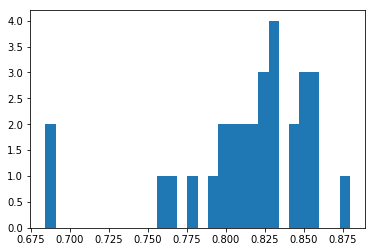

In [46]:
plt.hist(accuracies,bins=30)

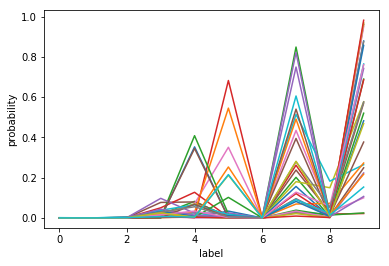

In [57]:
for pred in np.array(val_pred_pred)[:,7,:]:
    plt.plot(pred)
    plt.xlabel('label')
    plt.ylabel('probability')

In [51]:
np.array(val_pred_pred[:,0,:])

TypeError: list indices must be integers or slices, not tuple